# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a un dataset concreto

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [17]:
!pip install ucimlrepo

In [18]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [19]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [20]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


En este punto, puedes hacer cualquier otro análisis exploratorio que creas conveniente.

In [21]:
import numpy as np
import pandas as pd

print (X.shape)
print (y.shape)

#fila_210 = X.loc[209, ['cylinders', 'acceleration']]
#print(fila_210)

print (type(X))
print (type(y))


(398, 7)
(398, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [22]:
X.tail()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
393,140.0,4,86.0,2790,15.6,82,1
394,97.0,4,52.0,2130,24.6,82,2
395,135.0,4,84.0,2295,11.6,82,1
396,120.0,4,79.0,2625,18.6,82,1
397,119.0,4,82.0,2720,19.4,82,1


In [23]:
y.tail()

,mpg
393,27.0
394,44.0
395,32.0
396,28.0
397,31.0


A continuación, crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en millas por galón) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo, pero usa los parámetros que quieras en cuanto a color de los puntos, grids etc.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualiza(df, y, nombre_columna):
    """
    Plots a scatter graph between a feature variable and the target variable.
    df -> dataframe that contains the features
    y -> dataframe that contains the target variable
    nombre_columna -> name of the feature variable to plot
    """
    #x = df[nombre_columna].tolist()    # using a Python list (without the column name)
    #x = df[nombre_columna].values      # using a NumPy array (without the column name)
    x = df[nombre_columna]
    x_label = nombre_columna.capitalize()
    y_label = y.columns[0].capitalize()
    plt.scatter(x, y, s = 10, c = 'r', label = x_label)
    plt.grid(True)  # Adding a grid to facilitate reading of datapoints on graph
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(y_label + "  vs  " + x_label)
    plt.legend() 
    plt.show()
    return


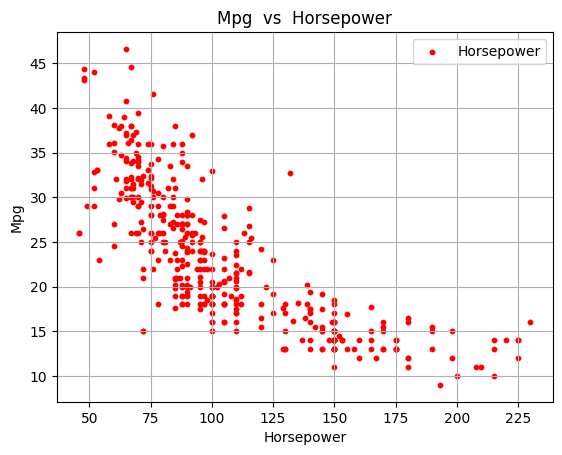

In [25]:
visualiza(X, y, 'horsepower')

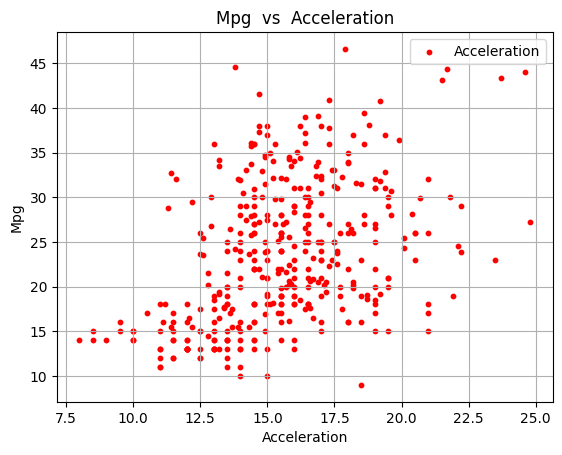

In [26]:
visualiza(X, y, 'acceleration')

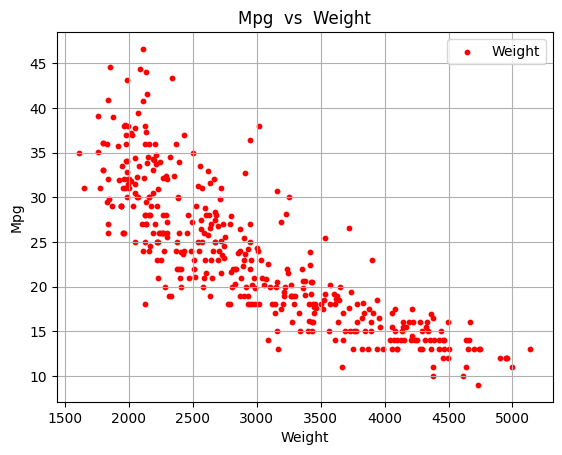

In [27]:
visualiza(X, y, 'weight')

IMPORTANTE: Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

En este punto vamos a dar un paso atrás y olvidarnos de los datos de consumo por un momento, porque el algoritmo que vamos a implementar serviría para cualquier conjunto de datos.

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [28]:
X

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1
394,97.0,4,52.0,2130,24.6,82,2
395,135.0,4,84.0,2295,11.6,82,1
396,120.0,4,79.0,2625,18.6,82,1


In [76]:
import numpy as np
import pandas as pd

def pesos_ols_multivariant(X, y, column_index = None):

    """
    Calcula los coeficientes (pesos) de la línia de regresión según el método OLS multivariante
    ("Ordinary Least Squares) entre las variables:
    - X: matriz (np.matrix) de features (se usará la columna 0 a menos que se pase otra)
    - y: variable target (puede ser Series, DataFrame, ndarray o matrix)
    """

    ###############################################################################################
    # 1. Obtiene la variable X_matrix en forma de matriz de features de una columna
    #    y comprueba que las dimensiones sean las correctas:

    # Comprueba que el formato sea DataFrame o Series o matriz, y transforma a matriz.
    if isinstance(X,pd.DataFrame) or isinstance(X,pd.Series):
        X_matrix = X.to_numpy()   
    elif isinstance(X,np.ndarray):
        if X.ndim == 1:
            X_matrix = X.reshape(-1, 1)
        else:
            X_matrix = X
    else:
        raise TypeError("Target must be a dataframe, series or ndarray.")

    # Comprueba que el número de filas es mayor que el de columnas. Si no lo es, calcula la traspuesta.
    if X_matrix.shape[0] <= X_matrix.shape[1]:
        print("Warning: the calculation is done using the features transposed matrix.\n")
        X_matrix = X_matrix.T

    # Si se ha pasado columna, crea la matriz de una columna que contiene la variable de features con la que calcular la regresión.
    if X_matrix.shape[1] > 1 and column_index != None:
        X_matrix = np.asarray(X_matrix[:, column_index]).reshape(-1, 1)

    ###############################################################################################
    # 2. Obtiene la variable y_target en forma de matriz de una columna:

    # Comprueba que el formato sea DataFrame de una columna o Series o matriz de una columna.
    if isinstance(y,pd.DataFrame):
        if y.shape[1] != 1:
            print("The target dataframe should have only one column. This program will use the first one.")
        y_target = y.iloc[:,0]   #Transforma el DataFrame en NumPy array.
    elif isinstance(y,pd.Series):
        y_target = y
    elif isinstance(y,np.ndarray):
        y_target = y
    else:
        raise TypeError("Target must be a dataframe, series or ndarray")

    ###############################################################################################
    # 3. Agrega la columna de 1s para el término independiente (bias)    
    ones = np.ones((X_matrix.shape[0],1))
    X_b = np.hstack((ones, X_matrix))
    #print(X_b)
    
    ###############################################################################################
    # 4. Calcula los pesos  
    # Primero calcula el rango de la matriz de productos internos para decidir si utilizar la matriz inversa o pseudoinversa.    

    XT_X = X_b.T @ X_b   # Matriz de productos internos (Gram matrix)
    rank = np.linalg.matrix_rank(XT_X)   #Cálculo del rango
    
    if rank == XT_X.shape[0]:
        w = np.linalg.inv(XT_X) @ X_b.T @ y_target   # Usando matriz inversa
    else:    
        print("Non-invertible matrix: using pseudoinverse instead.\n")
        w = np.linalg.lstsq(X_b, y_target)  # Usando matriz pseudoinversa (same as: w = np.linalg.pinv(X_b) @ y_target)
    
    
    ###############################################################################################
    # 5. Imprime y devuelve el array de pesos.

    w = w.flatten()   # Por si se da el caso de obtener una tupla de arrays, con los pesos en el primer elemento.
    print(f"The resulting weights of the multivariant OLS linear model are {w}.\n")
    
    return w, X_matrix


In [31]:
X_prueba = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y_prueba = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])

pesos_ols_multivariant(X_prueba,y_prueba)


The resulting weights of the linear model are [-2.29223802e+06  5.92536529e+01  1.20780450e+03].



(array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03]),
 array([[1710, 2003],
        [1262, 1976],
        [1786, 2001],
        [1717, 1915],
        [2198, 2000],
        [1362, 1993],
        [1694, 2004],
        [2090, 1973],
        [1774, 1931],
        [1077, 1939]]))

In [75]:
import numpy as np
import pandas as pd

def pesos_ols(X, y, column_index = 0):

    """
    Calcula los coeficientes (pesos) de la línia de regresión según el método OLS univariante
    ("Ordinary Least Squares) entre las variables:
    - X: matriz (np.matrix) de features (se usará la columna 0 a menos que se pase otra)
    - y: variable target (puede ser Series, DataFrame, ndarray o matrix)
    """

    ###############################################################################################
    # 1. Obtiene la variable X_matrix en forma de matriz de features de una columna
    #    y comprueba que las dimensiones sean las correctas:

    # Comprueba que el formato sea DataFrame o Series o matriz, y transforma a matriz.
    if isinstance(X,pd.DataFrame) or isinstance(X,pd.Series):
        X_matrix = X.to_numpy()   
    elif isinstance(X,np.ndarray):
        if X.ndim == 1:
            X_matrix = X.reshape(-1, 1)
        else:
            X_matrix = X
    else:
        raise TypeError("Target must be a dataframe, series or ndarray.")

    # Comprueba que el número de filas es mayor que el de columnas. Si no lo es, calcula la traspuesta.
    if X_matrix.shape[0] <= X_matrix.shape[1]:
        print("Warning: the calculation is done using the features transposed matrix.\n")
        X_matrix = X_matrix.T

    # Crea la matriz de una columna que contiene la variable de features con la que calcular la regresión.
    if X_matrix.shape[1] > 1:
        X_matrix = np.asarray(X_matrix[:, column_index]).reshape(-1, 1)

    ###############################################################################################
    # 2. Obtiene la variable y_target en forma de matriz de una columna:

    # Comprueba que el formato sea DataFrame de una columna o Series o matriz de una columna.
    if isinstance(y,pd.DataFrame):
        if y.shape[1] != 1:
            print("The target dataframe should have only one column. This program will use the first one.")
        y_target = y.iloc[:,0]   #Transforma el DataFrame en NumPy array.
    elif isinstance(y,pd.Series):
        y_target = y
    elif isinstance(y,np.ndarray):
        y_target = y
    else:
        raise TypeError("Target must be a dataframe, series or ndarray")

    ###############################################################################################
    # 3. Agrega la columna de 1s para el término independiente (bias)    
    ones = np.ones((X_matrix.shape[0],1))
    X_b = np.hstack((ones, X_matrix))
    #print(X_b)
    
    ###############################################################################################
    # 4. Calcula los pesos  
    # Primero calcula el rango de la matriz de productos internos para decidir si utilizar la matriz inversa o pseudoinversa.    

    XT_X = X_b.T @ X_b   # Matriz de productos internos (Gram matrix)
    rank = np.linalg.matrix_rank(XT_X)   #Cálculo del rango
    
    if rank == XT_X.shape[0]:
        w = np.linalg.inv(XT_X) @ X_b.T @ y_target   # Usando matriz inversa
    else:    
        print("Non-invertible matrix: using pseudoinverse instead.\n")
        w = np.linalg.lstsq(X_b, y_target)  # Usando matriz pseudoinversa (same as: w = np.linalg.pinv(X_b) @ y_target)
    
    
    ###############################################################################################
    # 5. Imprime y devuelve los pesos: w[0] = intercept y w[1] = gradiente.

    w = w.flatten()   # Por si se da el caso de obtener una tupla de arrays, con los pesos en el primer elemento.
    print(f"The resulting weights of the univariant OLS linear model are {w}.\n")
    
    return w, X_matrix


In [12]:
#pesos_ols(X[['weight']].values, y)
pesos_ols(X,y,3)

The resulting weights of the linear model are [183845.82320235  40415.66453301].



(array([183845.82320235,  40415.66453301]),
 array([[ 0.37020659],
        [-0.48234664],
        [ 0.51483616],
        [ 0.38352774],
        [ 1.29888065]]))

In [33]:
# Array de prueba!!
X_prueba = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y_prueba = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])

pesos_ols(X_prueba, y_prueba)


The resulting weights of the linear model are [45198.45332662    86.9475385 ].



(array([45198.45332662,    86.9475385 ]),
 array([[1710],
        [1262],
        [1786],
        [1717],
        [2198],
        [1362],
        [1694],
        [2090],
        [1774],
        [1077]]))

Hemos implementado el algoritmo de mínimos cuadrados y lo hemos probado en un array de tamaño 2x10. Como pista, el resultado que he obtenido para este array de prueba es el siguiente:

array([-2.29223802e+06, 5.92536529e+01, 1.20780450e+03])

### Conclusión sobre la función de pesos:

La función pesos_ols() me da un resultado correcto para los datos del consumo de los coches en función de su peso (comparando con el programa de sklearn -ver más abajo en el último apartado de la parte 1.)

Cuando lo aplico al array de prueba, calcula la traspuesta y, como no se ha pasado ningún índice de columno, por defecto calcula la regresión lineal con la primera columna (la de índice 0). Para ver si el resultado tiene sentido, he utilizado la función visualiza_con_regresion_linear() (apartado 1.3 de esta práctica) y la recta de regresión parece adecuarse bien a los 10 puntos utilizados.

La función pesos_ols_multivariant() es prácticamente idéntica pero no impone un índice de columna. Si se pasa un índice, trabaja sólo con esta columna; en caso contrario, trabaja con todas las columnas de X. En el caso del array de prueba, primero calcula la traspuesta (porque hay más columnas que filas) y luego resuelve el modelo con las dos columnas resultantes, obteniendo el array esperado para los pesos: array([-2.29223802e+06, 5.92536529e+01, 1.20780450e+03]). 

Por lo tanto, sé que el programa funciona correctamente, tanto en modo univariante (pesos_ols()) como en modo multivariante (pesos_ols_multivariant()).  

Calculating linear regression.


The resulting weights of the linear model are [45198.45332662    86.9475385 ].

Calculating series of predicted values.

Plotting graph.



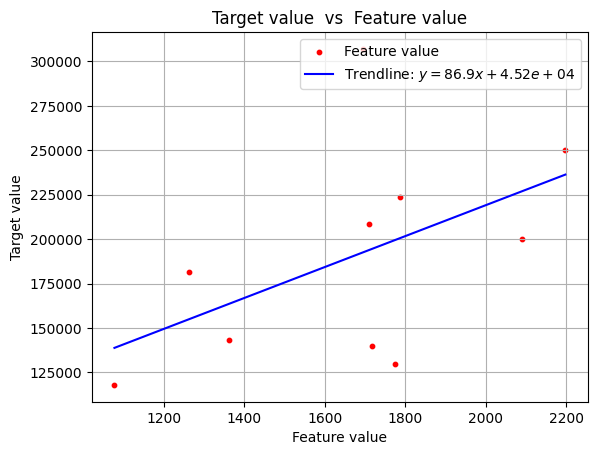

Program reached the end successfully.



In [34]:
visualiza_con_regresion_linear(X_prueba,y_prueba)

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

In [35]:
# TODO Aplica el modelo y dibuja la recta junto con los datos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def visualiza_con_regresion_linear(df, y, nombre_columna = None):
    """
    Calculates the intercept and gradient of the line of best fit that relates
    a feature variable and the target variable. 
    Then plots the scatter graph containing the data and the trendline, with its equation.
        df -> dataframe that contains the features
        y -> dataframe that contains the target variable
        nombre_columna -> name of the feature variable
    """
    
    # 1. Calling function pesos_ols(df,y) to calculate linear regression values.
    print("Calculating linear regression.\n")
    if isinstance(df, pd.DataFrame) and nombre_columna != None:
        regression, X_data = pesos_ols(df[[nombre_columna]].values,y)
    else:
        regression, X_data = pesos_ols(df, y)
    intercept = regression[0]
    gradient = regression[1]
    X_as_df = pd.DataFrame(X_data, columns = [nombre_columna])

    # 2. Calculating series of predicted values for drawing the trendline
    print("Calculating series of predicted values.\n")
    #x_hat = np.linspace(X_data.min(),X_data.max(),10)
    x_hat = np.linspace(X_as_df[nombre_columna].min(), X_as_df[nombre_columna].max(), 10)
    y_hat = intercept + x_hat*gradient
    x_hat_label = f"Trendline: $y = {gradient:.3g}x + {intercept:.3g}$"   # Using 3 significant figures
    #x_hat_label = f"Trendline: $y = {gradient:.2f}x + {(intercept:.2f}$"  # Using 2 decimal places

    # 3. Plotting data and trendline
    print("Plotting graph.\n")
    x = X_as_df
    if nombre_columna == None:
        x_label = 'Feature value'
    else:
        x_label = nombre_columna.capitalize()
    if isinstance(y,pd.DataFrame) and y.columns[0] != None:
        y_label = y.columns[0].capitalize()
    else: 
        y_label = 'Target value'
    plt.scatter(x, y, s = 10, c = 'r', label = x_label)  # Plots dataset
    plt.plot(x_hat, y_hat, marker = '', c = 'b', label = x_hat_label)  # Plots trendline with no markers
    plt.grid(True)  # Adds a grid to facilitate reading of datapoints on graph
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{y_label}  vs  {x_label}")
    plt.legend()
    plt.show()
    print("Program reached the end successfully.\n")
    return

Calculating linear regression.

The resulting weights of the linear model are [ 4.63173644e+01 -7.67661006e-03].

Calculating series of predicted values.

Plotting graph.



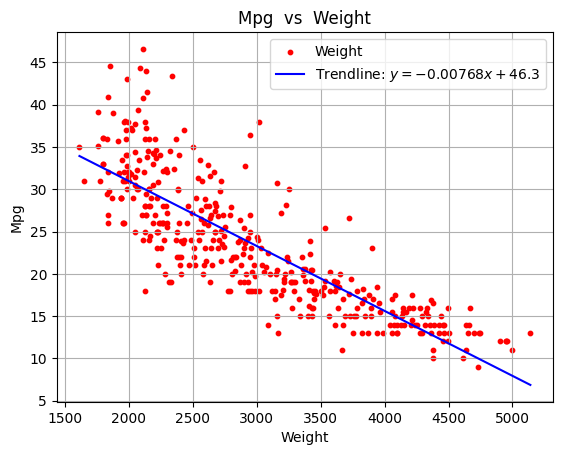

Program reached the end successfully.



In [36]:
visualiza_con_regresion_linear(X,y,'weight')

Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [37]:
!pip install scikit-learn

In [38]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)

Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn.

Con mi programa he encontrado el resultado siguiente:
"The intercept w0 is 46.317364420265655 and the gradient w1 is -0.007676610063926457."
Los resultados son coincidentes, con la única diferencia que mi programa da muchas más cifras significativas, que realmente no son importantes ya que los datos estan lejos del modelo lineal ideal. 

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal


Los dos métodos dan resultados parecidos cuando funcionan bien (esto se ve en la prueba que hago al final del punto 2.1). En general, el método "Ordinary Least Squares" (OLS) dará una solución exacta, mientras que la solución del método del descenso del gradiente (GD) será una aproximación, pero tan precisa como se requiere. Cuando los datos sean más voluminosos, el método OLS tardará más en ejecutarse y además puede generar problemas al tenerse que invertir una matriz (la solución de la pseudoinversa en el caso de matrices no invertibles es buena pero también es lenta). No obstante, para pequeñas cantidades de datos, el método OLS puede incluso ser más rápido porqué no requiere otros parámetros como el learning rate, el vector de pesos de partida inicial o el número de iteraciones. Un inconveniente importante del método GD es que no siempre converge y a veces es necesario probar diferentes parámetros antes de que dé una solución estable.

### 2. Optimización con descenso del gradiente

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones 
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

In [66]:
import numpy as np

def gradient_descent(X, y, w0 = np.array([0, 1]).reshape((2,1)), n_iter = 50, eta = 0.2): #Damos unos valores por defecto, menos para los datos de entrada.
    """
    Parámetros:
        X = np.array de valores del feature
        y = np.array de valores del target
        w0 = vector inicial de coeficientes desde el que empezar a iterar. Por defecto se escogerá la media de las "y" como 
             intercept y el gradiente obtenido con el primero y último puntos de los arrays de entrada como gradiente.
        n_iter = número de iteraciones. Por defecto se escogerá 50.
        eta = learning rate. Por defecto se escogerá 0.2.
    Salida:
        np.array(w_iter) = array con los coeficientes resultantes de las iteraciones
        np.array(loss_iter) = array con el valor de la función en cada paso del algoritmo ("loss function")
    
    """
    # Define la función que calcule n_iter iteraciones del descenso del gradiente
    # Inicializamos variables

    loss_iter = [np.inf] #Creates a list for the loss function with "infinity" as the first element (the value of the loss should decrease through the iterations)
    w_iter = [w0] #Creates a list for the coefficients with w0 as the first element.
    w = w0  #Keeps track of latest coefficients

    # TODO 1 Añade la columna de 1s

    #Sólo sería necesario si los datos de entrada no estuviesen en formato Numpy array
    #X = np.array(X)  
    #y = np.array(y)

    n = X.shape[0]
    ones = np.ones((n,1))
    X_b = np.hstack((ones, X))
       
    # TODO 2 Haz un bucle para las iteraciones 
    # TODO 3 Dentro del bucle tendrás que actualizar el error y los pesos y añadirlos a las listas

    for i in range(n_iter):

        # Iteraciones
        y_hat = X_b @ w  #Trabajamos con la columna de 1s para calcular también el intercept.
        w = w - eta * (X_b.T @ (X_b @ w - y)) #Utilizamos el descenso del gradiente para calcular los nuevos pesos.
    
        # Actualización del error y de los pesos, añadiendólos a las listas
        RSS_error = 0.5 * np.sum((y_hat - y)**2) #Ésta es la función que queremos minimizar
        w_iter.append(w)
        loss_iter.append(RSS_error)

    # Devuelve los resultados
    return np.array(w_iter), np.array(loss_iter)


In [78]:
eta = 0.01 
iteraciones = 2000 

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))

y = np.array([208500, 181500, 223500, 140000, 250000]).reshape((5,1))
X = np.array( [[  0.37020659],
               [  -0.48234664],
               [  0.51483616],
               [  0.38352774],
               [  1.29888065]])

weights, loss = gradient_descent(X, y, w0, iteraciones, eta)
#weights, loss = gradient_descent(X, y)

print(f'Weights obtained with the gradient descent method: {weights[-1]}.\n')

pesos, X_out = pesos_ols_multivariant(X, y)


Weights obtained with the gradient descent method: [[183845.82320222]
 [ 40415.66453324]].

The resulting weights of the multivariant OLS linear model are [183845.82320235  40415.66453301].



### Respuesta a la pregunta 1.4 - Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal. 
Como se ve justo arriba, los dos métodos dan resultados parecidos y en este caso ambos funcionan bien. 
En general, el método OLS es más preciso pero quizás sea más lento de ejecutar cuando hay muchos datos y también puede generar problemas computacionales con la matriz inversa o la pseudoinversa. 
Por el contrario, el método GD no siempre converge pero me parece muy rápido, una vez hayamos encontrado valores adecuados para el learning rate y demás parámetros iniciales.

### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [70]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)

(398, 1)
(398, 1)


Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

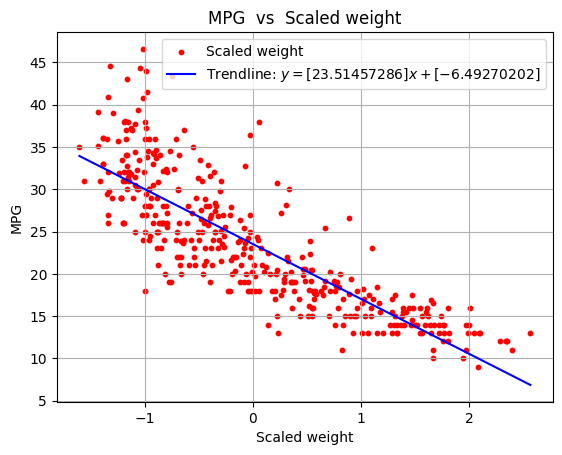

In [97]:
# TODO Aplica el modelo y dibuja la recta junto con los datos

X = auto_mpg.data.features
y = auto_mpg.data.targets

# Escalamos la variable x 

X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

X_gd = (X_np - X_np.mean()) / X_np.std()
y_gd = y_np

# TODO 1 Punto inicial y learning rate
np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))
n_iter = 300
eta = 0.002 #The learning rate must be small as we are working with some values (standardized)

# TODO 2 Aplicamos el algoritmo
coefficients, losses = gradient_descent(X_gd, y_gd, w0, n_iter, eta)

# Límites de los ejes
x_max = np.max(X_gd) + 1
x_min = np.min(X_gd) -1

# TODO 3 Dibuja la gráfica

# Scatter (dataset)
x = X_gd
y = y_gd
x_label = 'Scaled weight'
y_label = 'MPG'
plt.scatter(x, y, s = 10, c = 'r', label = x_label)  

# Gradient descent linear model
x_hat = np.linspace(x.min(), x.max(), 10)
y_hat = coefficients[-1][0] + x_hat*coefficients[-1][1]
x_hat_label = f"Trendline: $y = {coefficients[-1][0]}x + {coefficients[-1][1]}$"  
plt.plot(x_hat, y_hat, marker = '', c = 'b', label = x_hat_label)  # Plots trendline with no markers

plt.grid(True)  # Adds a grid to facilitate reading of datapoints on graph
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(f"{y_label}  vs  {x_label}")
plt.legend()
plt.show()